In [1]:
# import packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from math import log
import urllib
import csv
pd.set_option('display.max_rows', 10)

### Downloading the Education Index dataset.
Like all our data, the education index dataset is hosted on github. We initially attempted to use the pandas `read_csv` function to process it but this was unsuccessful due to the way the csv document is structured, which led us to fall back on the lower-level `csv` library. The dataset also contained other unusual formatting quirks, for example, all columns with data were separated by empty columns.

In [2]:
# Education Index dataset.
ei_url = 'https://raw.githubusercontent.com/iatrogenic/Solow-TPROG/main/data/Education_index.csv'

# We parse it manually below, using python's csv module.
with urllib.request.urlopen(ei_url) as rsp:
    # decode latin1 since some lines contain non-UTF8 characters.
    csvfile = [l.decode('latin1') for l in rsp.readlines()]
    ei = csv.reader(csvfile)
    # there was some extra, unecessary information in the dataset, which is removed here.
    raw = [row[1:] for row in list(ei)[6:-1]]
    # More weird formatting: all the even (excluding 0th column) columns are empty. They are removed below.
    formatted_rows = []
    for row in raw:
        formatted_rows.append([row[0]] + row[1::2])

In [3]:
# Adds column names and converts the list of data to a pandas DataFrame object.
cols = ['country'] + list(range(1990, 2020))
# creates education dataframe from the processed list, with the columns defined above.
education = pd.DataFrame(formatted_rows, columns=cols)
education

,country,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,0.122,0.133,0.145,0.156,0.168,0.179,0.190,0.202,0.213,...,0.372,0.374,0.390,0.398,0.403,0.405,0.406,0.408,0.413,0.414
1,Albania,0.583,0.588,0.557,0.542,0.541,0.550,0.557,0.569,0.579,...,0.671,0.714,0.739,0.749,0.758,0.753,0.745,0.747,0.743,0.746
2,Algeria,0.385,0.395,0.405,0.414,0.424,0.431,0.443,0.458,0.473,...,0.626,0.644,0.639,0.639,0.652,0.659,0.660,0.665,0.668,0.672
3,Andorra,..,..,..,..,..,..,..,..,..,...,0.670,0.671,0.724,0.714,0.725,0.718,0.722,0.713,0.720,0.720
4,Angola,..,..,..,..,..,..,..,..,..,...,0.398,0.423,0.435,0.447,0.460,0.472,0.487,0.498,0.500,0.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,Sub-Saharan Africa,0.285,0.290,0.297,0.304,0.310,0.319,0.326,0.332,0.340,...,0.422,0.429,0.437,0.449,0.452,0.457,0.460,0.465,0.466,0.471
202,Least Developed Countries,0.223,0.228,0.233,0.239,0.244,0.251,0.259,0.268,0.277,...,0.388,0.396,0.403,0.408,0.411,0.419,0.424,0.430,0.431,0.437
203,Small Island Developing States,0.466,0.471,0.477,0.483,0.485,0.492,0.500,0.506,0.512,...,0.607,0.613,0.604,0.609,0.615,0.621,0.624,0.628,0.627,0.633
204,Organization for Economic Co-operation and Dev...,0.679,0.688,0.681,0.709,0.720,0.729,0.735,0.728,0.747,...,0.818,0.824,0.828,0.835,0.841,0.846,0.850,0.851,0.852,0.852


Here we begin incorporating the other two datasets that we'll be using: the World Bank and the Penn's World Table dataset. Both are imported from GitHub.

In [4]:
# import World Bank data

pop_growth = pd.read_csv('https://raw.githubusercontent.com/iatrogenic/Solow-TPROG/main/data/e65a7cf4-b4af-4fca-a1ef-7cd396465237_Data.csv')
pop_growth = pd.DataFrame(pop_growth)

gdp_growth = pd.read_csv('https://raw.githubusercontent.com/iatrogenic/Solow-TPROG/main/data/9dafeb4d-c5ca-4008-9497-8f9612ce8967_Data.csv')
gdp_growth = pd.DataFrame(gdp_growth)

savings = pd.read_csv('https://raw.githubusercontent.com/iatrogenic/Solow-TPROG/main/data/11ce0515-b87a-4bff-8ded-98e24d00470f_Data.csv')
savings = pd.DataFrame(savings)

# import Penn World Table dataset

pwt = pd.read_excel('https://github.com/iatrogenic/Solow-TPROG/blob/main/data/data_PWT/pwt100.xlsx?raw=true', sheet_name = 'Data')
pwt = pd.DataFrame(pwt)

In [5]:
# create a dataframe with World Bank data

df1 = pd.concat([gdp_growth, pop_growth, savings], axis = 1) # merge dataframes
df1 = df1.loc[:,~df1.columns.duplicated()] # remove duplicate columns
df1 = df1.dropna()
df1.reset_index(drop = True)
df1

# delete two unecessary columns
del df1['Country Name']
del df1['Time Code']

# rename columns
df1.rename(columns = {'Country Code': 'country_code'}, inplace = True)
df1.rename(columns = {'Time': 'year'}, inplace = True)
df1.rename(columns = {'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]': 'gdp_growth'}, inplace = True)
df1.rename(columns = {'Population growth (annual %) [SP.POP.GROW]': 'pop_growth'}, inplace = True)
df1.rename(columns = {'Gross capital formation (% of GDP) [NE.GDI.TOTL.ZS]': 'savings'}, inplace = True)

# remove rows for years before 2000 and after 2018
df1 = df1[df1['year'] > 1989]
df1 = df1[df1['year'] < 2019]

# convert to numeric
df1['gdp_growth'] = pd.to_numeric(df1['gdp_growth'], errors='coerce')
df1['pop_growth'] = pd.to_numeric(df1['pop_growth'], errors='coerce')
df1['savings'] = pd.to_numeric(df1['savings'], errors='coerce')

pd.set_option('display.max_rows', 10)

In [6]:
# create a dataframe with Penn World dataset

df2 = pwt[['countrycode', 'country', 'year', 'labsh', 'delta', 'rgdpna', 'pop', 'hc']] # keep columns we need

# rename columns
df2.rename(columns = {'countrycode': 'country_code'}, inplace = True)
df2.rename(columns = {'labsh': 'labour_share_income'}, inplace = True)
df2.rename(columns = {'rgdpna': 'real_gdp'}, inplace = True)

# remove rows for years before 1989 and after 2018
df2 = df2[df2['year'] > 1989]
df2 = df2[df2['year'] < 2019]

/Users/lack/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Further problems relating to the Education Index dataset presented themselves here: the time dimension was horizontal, i.e. the years were specified as column names; in our other two datasets we have the reverse: time specified vertically, through rows. Thus the first objective was to reshape the dataframe so as to have the `year` field vertically, to facilitate the dataframe merging that takes place later in this notebook. There was also another issue: the Education Index database did not include country codes, and thus there were spelling differences in country names. We decided to alter the `education` dataframe by replacing country names by their corresponding country codes. To accomplish this, we used the country codes specified in the World Bank dataset to create a dictionary, i.e. a mapping
$$ \text{code_map}  : \{ \text{Country Names} \} \to \{ \text{Country Codes} \}. $$
The differences in the spelling of country names across datasets required a large `if` statement to deal with each individual mismatch separately. We also removed groups of countries from the data, which have no corresponding country code.

In [7]:
# create country name -> country code map
code_map = {}
for row in pop_growth[['Country Name', 'Country Code']].drop_duplicates().values.tolist():
    code_map[row[0]] = row[1]
    
# transform time to vertical so as to merge with the rest of the dataframes later on
t_education = []
edu_list = education.values.tolist()
for row in edu_list:
    cntr = row[0]
    for year in range(1990, 2020):
        if cntr.strip() == 'Bahamas':
            t_education.append(['BHS', year, row[year - 1989]])
        elif cntr.strip() == 'Bolivia (Plurinational State of)':
            t_education.append(['BOL', year, row[year - 1989]])
        elif cntr.strip() == 'Congo (Democratic Republic of the)':
            t_education.append(['COD', year, row[year - 1989]])
        elif cntr.strip() == 'Congo':
            t_education.append(['COG', year, row[year - 1989]])
        elif cntr.strip() == 'Czechia':
            t_education.append(['CZE', year, row[year - 1989]])
        elif cntr.strip() == "Côte d'Ivoire":
            t_education.append(['CIV', year, row[year - 1989]])
        elif cntr.strip() == "Egypt":
            t_education.append(['EGT', year, row[year - 1989]])
        elif cntr.strip() == "Eswatini (Kingdom of)":
            t_education.append(['SWZ', year, row[year - 1989]])
        elif cntr.strip() == "Gambia":
            t_education.append(['GMB', year, row[year - 1989]])
        elif cntr.strip() == "Hong Kong, China (SAR)":
            t_education.append(['HKG', year, row[year - 1989]])
        elif cntr.strip() == "Iran (Islamic Republic of)":
            t_education.append(['IRN', year, row[year - 1989]])
        elif cntr.strip() == "Korea (Republic of)":
            t_education.append(['KOR', year, row[year - 1989]])
        elif cntr.strip() == "Kyrgyzstan":
            t_education.append(['KGZ', year, row[year - 1989]])
        elif cntr.strip() == "Lao People's Democratic Republic":
            t_education.append(['LAO', year, row[year - 1989]])
        elif cntr.strip() == "Micronesia (Federated States of)":
            t_education.append(['FSM', year, row[year - 1989]])
        elif cntr.strip() == "Moldova (Republic of)":
            t_education.append(['MDA', year, row[year - 1989]])
        elif cntr.strip() == "Palestine, State of":
            t_education.append(['PSE', year, row[year - 1989]])
        elif cntr.strip() == "Saint Kitts and Nevis":
            t_education.append(['KNA', year, row[year - 1989]])
        elif cntr.strip() == "Saint Lucia":
            t_education.append(['LCA', year, row[year - 1989]])
        elif cntr.strip() == "Saint Vincent and the Grenadines":
            t_education.append(['VCT', year, row[year - 1989]])
        elif cntr.strip() == "Slovakia":
            t_education.append(['SVK', year, row[year - 1989]])
        elif cntr.strip() == "Tanzania (United Republic of)":
            t_education.append(['TZA', year, row[year - 1989]])
        elif cntr.strip() == "Venezuela (Bolivarian Republic of)":
            t_education.append(['VEN', year, row[year - 1989]])
        elif cntr.strip() == "Viet Nam":
            t_education.append(['VNM', year, row[year - 1989]])
        elif cntr.strip() == "Yemen":
            t_education.append(['YEM', year, row[year - 1989]])
        elif cntr.strip() in ['Human Development', "Very high human development", 'High human development', "Medium human development","Low human development", 'Developing Countries', 'Regions', 'Arab States', 'East Asia and the Pacific', 'Europe and Central Asia', 'Latin America and the Caribbean', 'South Asia', 'Sub-Saharan Africa', 'Least Developed Countries', 'Small Island Developing States', 'Organization for Economic Co-operation and Development', 'World'] :
            break
        elif row[year - 1989] == "..":
            t_education.append([code_map[cntr.strip()], year, ''])
        else:
            # append the corresponding country code, year, and education index datapoint
            t_education.append([code_map[cntr.strip()], year, row[year - 1989]])
            
t_education = pd.DataFrame(t_education, columns = ['country_code', 'year', 'Education Index'])
t_education['year'] = t_education['year'].astype(float)
t_education['Education Index'] = pd.to_numeric(t_education['Education Index'], errors='coerce')

In [8]:
# merge dataframes containing data from World Bank (df1) and Penn World Table (df2)
df_aux = pd.merge(df1, df2).copy()
# merge the previous dataframe with the education index dataframe
df = pd.merge(df_aux, t_education, how='left', on=['country_code', 'year'])
df = df.dropna()

### Data transformation & creation

Three countries were dropped from our dataset for different reasons. Angola has zero savings, Qatar is a large $n+g+\delta$ outlier is an oil-producing country, and Ukraine is a small $n+g+\delta$ outlier.

In [9]:
# create: capital share of income & adjust decimals
df['capital_share_income'] = round(1 - df['labour_share_income'], 2)

# adjust scales & decimals
df['delta'] = df['delta'] * 100
df['real_gdp'] = df['real_gdp'] /10

# create: real gdp per capita & decimals
df['real_gdp_per_capita'] = df['real_gdp'] / df['pop']

df.drop(df.index[df['country_code'] == 'AGO'], inplace=True)
df.drop(df.index[df['country_code'] == 'QAT'], inplace=True)
df.drop(df.index[df['country_code'] == 'UKR'], inplace=True)

df = df.dropna() 

Here we compute $\alpha$, i.e. the capital share of income, which can be used to compute the theoretical coefficient $\frac{\alpha}{1 - \alpha}$.

In [10]:
# compute alpha (mean capital share of income)
df_alpha = df.groupby(['country_code'])['capital_share_income'].agg('mean')
alpha = df_alpha.mean()
round(alpha,4)

0.4776

We now compute $\delta$ and construct a new column $n + g + \delta$ which is added to the main dataframe `df`.

In [11]:
# compute g & delta
g_delta = df.groupby(['country_code'])['gdp_growth', 'delta'].agg('mean')
g = g_delta['gdp_growth'].mean()
delta = g_delta['delta'].mean()
print(g)
print(delta)

# create: (n + g + delta)
df['(n+g+delta)'] = df['pop_growth'] + df['gdp_growth'] + df['delta']

3.510307720213027
4.17250048808164


<ipython-input-11-0484b25e3401>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  g_delta = df.groupby(['country_code'])['gdp_growth', 'delta'].agg('mean')


In [12]:
# collapse regressor values in df to their arithmetic means
df_regression = df.groupby(['country_code'])['savings', '(n+g+delta)', 'pop', 'hc', 'Education Index'].agg('mean')
# ignore countries of small population
df_regression = df_regression[df_regression['pop'] > 1]
df_regression

<ipython-input-12-840f1c10b14c>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_regression = df.groupby(['country_code'])['savings', '(n+g+delta)', 'pop', 'hc', 'Education Index'].agg('mean')


,savings,(n+g+delta),pop,hc,Education Index
country_code,,,,,
ARG,17.515432,7.064752,38.496126,2.762353,0.749379
ARM,26.622005,5.725578,3.048512,3.082355,0.690714
AUS,25.985479,7.377094,20.442071,3.479699,0.897931
AUT,24.880684,6.400530,8.249491,3.178440,0.769207
BDI,11.208659,7.051932,7.618328,1.251119,0.275517
...,...,...,...,...,...
USA,21.313520,7.357352,291.347278,3.615634,0.871862
VEN,22.705581,8.675406,25.006332,2.253260,0.566480
ZAF,18.725002,8.536923,47.420789,2.298774,0.654655


### Correlation matrix
We observe in the correlation matrix that the World Bank's Human Capital data is very strongly correlated with the UN's Education Index, as one would expect. Both of these measures of human capital are also strongly correlated with real GDP in 2018.

In [13]:
df_regression.corr()

,savings,(n+g+delta),pop,hc,Education Index
savings,1.000000,0.275314,0.333724,0.199798,0.177391
(n+g+delta),0.275314,1.000000,0.242809,-0.548630,-0.554433
pop,0.333724,0.242809,1.000000,-0.058105,-0.076131
hc,0.199798,-0.548630,-0.058105,1.000000,0.961785
Education Index,0.177391,-0.554433,-0.076131,0.961785,1.000000


In [14]:
# compute real gdp per working age population in last year of sample (2018)
# and attach to df_regression

df_2018 = df[df.year == 2018]
df_2018 = df_2018.set_index('country_code', drop = True)
df_2018['real_gdp_per_capita_2018'] = df_2018['real_gdp_per_capita']

df_regression = pd.merge(df_regression, df_2018['real_gdp_per_capita_2018'], on = 'country_code', how='left')
df_regression

,savings,(n+g+delta),pop,hc,Education Index,real_gdp_per_capita_2018
country_code,,,,,,
ARG,17.515432,7.064752,38.496126,2.762353,0.749379,2247.770008
ARM,26.622005,5.725578,3.048512,3.082355,0.690714,1362.251662
AUS,25.985479,7.377094,20.442071,3.479699,0.897931,5299.561490
AUT,24.880684,6.400530,8.249491,3.178440,0.769207,5286.626790
BDI,11.208659,7.051932,7.618328,1.251119,0.275517,81.336090
...,...,...,...,...,...,...
USA,21.313520,7.357352,291.347278,3.615634,0.871862,6153.717469
VEN,22.705581,8.675406,25.006332,2.253260,0.566480,NaN
ZAF,18.725002,8.536923,47.420789,2.298774,0.654655,1266.141622


## Regression: Baseline
By baseline we mean that we are excluding a measurement of human capital from our regressors.

In [15]:
# set up dependent variable
df_regression = df_regression.dropna()
Y = df_regression['real_gdp_per_capita_2018'] # regressand
Y = np.log(Y) # natural log of regressand


In [16]:
# set up regressors

X1 = df_regression[['savings', '(n+g+delta)']] # regressors
X1 = np.log(X1) # natural log of regressors
X1 = sm.add_constant(X1) # add a constant to ensure mean of residuals = 0

# estimate OLS
# compute heteroskedasticity-robust standard errors ('HC3')

model = sm.OLS(Y,X1).fit(cov_type = 'HC3')
model.summary()

#sol_regr(Y, X1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     real_gdp_per_capita_2018   R-squared:                       0.290
Model:                                  OLS   Adj. R-squared:                  0.276
Method:                       Least Squares   F-statistic:                     19.07
Date:                      Tue, 30 Nov 2021   Prob (F-statistic):           9.89e-08
Time:                              23:56:57   Log-Likelihood:                -137.99
No. Observations:                       102   AIC:                             282.0
Df Residuals:                            99   BIC:                             289.9
Df Model:                                 2                                         
Covariance Type:                        HC3                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.8457      1.723      2.812      0.005       1.468       8.223
savings         1.8834      0.522      3.608      0.000       0.860       2.907
(n+g+delta)    -1.6198      0.309     -5.249      0.000      -2.225      -1.015
==============================================================================
Omnibus:                        1.420   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.492   Jarque-Bera (JB):                1.020
Skew:                          -0.234   Prob(JB):                        0.600
Kurtosis:                       3.146   Cond. No.                         58.7
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

## Regression: Baseline + Human Capital
We introduce an extra regressand, taken from Worldbank's dataset, called Human Capital.

In [17]:
X2 = df_regression[['savings', '(n+g+delta)', 'hc']] # regressors
X2 = np.log(X2) # natural log of regressors
X2 = sm.add_constant(X2) # add a constant to ensure mean of residuals = 0
X2 = X2.dropna()
model = sm.OLS(Y,X2).fit(cov_type = 'HC3')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     real_gdp_per_capita_2018   R-squared:                       0.716
Model:                                  OLS   Adj. R-squared:                  0.707
Method:                       Least Squares   F-statistic:                     128.7
Date:                      Tue, 30 Nov 2021   Prob (F-statistic):           7.33e-34
Time:                              23:56:57   Log-Likelihood:                -91.284
No. Observations:                       102   AIC:                             190.6
Df Residuals:                            98   BIC:                             201.1
Df Model:                                 3                                         
Covariance Type:                        HC3                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.4926      1.023      3.415      0.001       1.488       5.497
savings         0.1435      0.360      0.399      0.690      -0.561       0.848
(n+g+delta)     0.2240      0.311      0.720      0.471      -0.385       0.833
hc              3.2191      0.276     11.671      0.000       2.678       3.760
==============================================================================
Omnibus:                        8.147   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.017   Jarque-Bera (JB):               10.772
Skew:                          -0.384   Prob(JB):                      0.00458
Kurtosis:                       4.395   Cond. No.                         60.4
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

## Regression: Baseline + Education Index
Finally, we replace the human capital data by the UN's Education Index.

In [18]:
X3 = df_regression[['savings', '(n+g+delta)', 'Education Index']] # regressors
X3 = np.log(X3) # natural log of regressors
X3 = sm.add_constant(X3) # add a constant to ensure mean of residuals = 0
X3 = X3.dropna()
model = sm.OLS(Y,X3).fit(cov_type = 'HC3')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     real_gdp_per_capita_2018   R-squared:                       0.766
Model:                                  OLS   Adj. R-squared:                  0.758
Method:                       Least Squares   F-statistic:                     59.16
Date:                      Tue, 30 Nov 2021   Prob (F-statistic):           6.52e-22
Time:                              23:56:57   Log-Likelihood:                -81.504
No. Observations:                       102   AIC:                             171.0
Df Residuals:                            98   BIC:                             181.5
Df Model:                                 3                                         
Covariance Type:                        HC3                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.8708      0.914      8.608      0.000       6.079       9.663
savings             0.1501      0.325      0.462      0.644      -0.486       0.787
(n+g+delta)         0.1980      0.266      0.743      0.457      -0.324       0.720
Education Index     2.7584      0.306      9.008      0.000       2.158       3.359
==============================================================================
Omnibus:                        2.280   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.320   Jarque-Bera (JB):                1.684
Skew:                          -0.265   Prob(JB):                        0.431
Kurtosis:                       3.339   Cond. No.                         61.8
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

### Plots
Here we plot each of the regressors against the regressor.

In [19]:
dx = np.log(df_regression[['savings', '(n+g+delta)', 'hc']])
dy = pd.DataFrame(Y)

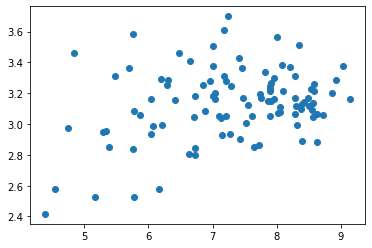

In [20]:
fig, ax = plt.subplots()
ax.scatter(dy['real_gdp_per_capita_2018'], dx['savings'])

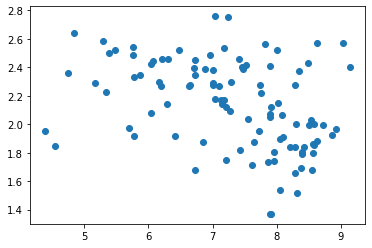

In [21]:
fig, ax = plt.subplots()
ax.scatter(dy['real_gdp_per_capita_2018'], dx['(n+g+delta)'])

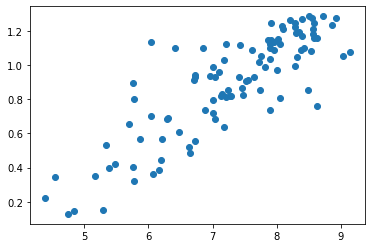

In [22]:
fig, ax = plt.subplots()
ax.scatter(dy['real_gdp_per_capita_2018'], dx['hc'])

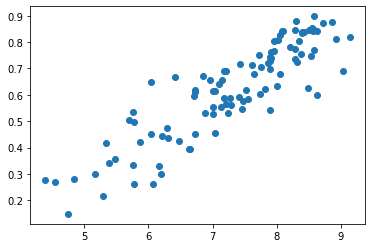

In [23]:
fig, ax = plt.subplots()
ax.scatter(dy['real_gdp_per_capita_2018'], df_regression['Education Index'])